In [ ]:
!git clone https://github.com/telexyz/kim.git
%cd kim
!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
!pip3 install pytest numpy numdifftools pybind11 requests
# !nvidia-smi

In [ ]:
!git pull
!make && python3 -m pytest -v -k "matmul and cuda"

## Cuda MatMul Performance

In [26]:
import numpy as np
import torch
from kim import backend_ndarray as nd
k = 2**11
# numpy matmul
A_np = np.random.randn(k, k)
B_np = np.random.randn(k, k)
# cpu matmul
A_cpu = nd.array(A_np, device=nd.cpu())
B_cpu = nd.array(B_np, device=nd.cpu())
# cuda simple matmul
A_cuda_simple = nd.array(A_np[:-2,:-2], device=nd.cuda())
B_cuda_simple = nd.array(B_np[:-2,:-2], device=nd.cuda())
# cuda shared mememory tiled matmul
A_cuda_best = nd.array(A_np, device=nd.cuda())
B_cuda_best = nd.array(B_np, device=nd.cuda())
## torch
A_torch = torch.tensor(A_np)
B_torch = torch.tensor(B_np)

In [18]:
%%timeit
A_np @ B_np

554 ms ± 92.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
A_cuda_simple @ B_cuda_simple

98.6 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%%timeit
A_cuda_best @ B_cuda_best

12.1 ms ± 93.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%%timeit
torch.cuda.FloatTensor(k, k) @ torch.cuda.FloatTensor(k, k)

3.43 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## GAN
https://github.com/dlsyscourse/public_notebooks/blob/main/17_generative_adversarial_networks_implementation.ipynb

In [3]:
import kim
import numpy as np
from kim import nn
from kim import init
from matplotlib import pyplot as plt

In [4]:
A = np.array([[1, 2], [-0.2, 0.5]]).astype("float32")
mu = np.array([2, 1]).astype("float32")
# total number of sample data to generated
num_sample = 3200
data = np.random.normal(0, 1, (num_sample, 2)).astype("float32") @ A + mu

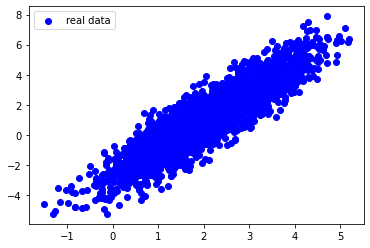

In [5]:
plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.legend()

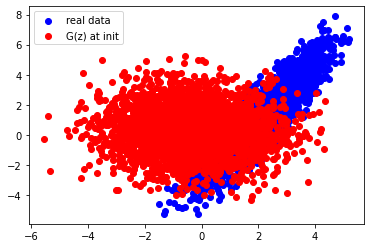

In [6]:
model_G = nn.Sequential(nn.Linear(2, 2))

def sample_G(model_G, num_samples):
    Z = kim.Tensor(np.random.normal(0, 1, (num_samples, 2)).astype("float32"))
    fake_X = model_G(Z)
    return fake_X.numpy()

fake_data_init = sample_G(model_G, 3200)
plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.scatter(fake_data_init[:,0], fake_data_init[:,1], color="red", label="G(z) at init")
plt.legend()

In [7]:
model_D = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)

loss_D = nn.SoftmaxLoss()

opt_G = kim.optim.Adam(model_G.parameters(), lr=0.01)

In [8]:
def update_G(Z, model_G, model_D, loss_D, opt_G):
    fake_X = model_G(Z)
    fake_Y = model_D(fake_X)
    batch_size = Z.shape[0]
    ones = init.ones(batch_size, dtype="int32")
    loss = loss_D(fake_Y, ones)
    loss.backward()
    opt_G.step()

opt_D = kim.optim.Adam(model_D.parameters(), lr=0.01)

In [9]:
def update_D(X, Z, model_G, model_D, loss_D, opt_D):
    fake_X = model_G(Z).detach()
    fake_Y = model_D(fake_X)
    real_Y = model_D(X)
    assert X.shape[0] == Z.shape[0]
    batch_size = X.shape[0]
    ones = init.ones(batch_size, dtype="int32")
    zeros = init.zeros(batch_size, dtype="int32")
    loss = loss_D(real_Y, ones) + loss_D(fake_Y, zeros)
    loss.backward()
    opt_D.step()

In [10]:
def train_gan(data, batch_size, num_epochs):
    assert data.shape[0] % batch_size == 0
    for epoch in range(num_epochs):
        begin = (batch_size * epoch) % data.shape[0]
        X = data[begin: begin+batch_size, :]
        Z = np.random.normal(0, 1, (batch_size, 2))
        X = kim.Tensor(X)
        Z = kim.Tensor(Z)
        update_D(X, Z, model_G, model_D, loss_D, opt_D) 
        update_G(Z, model_G, model_D, loss_D, opt_G)

train_gan(data, 32, 2000)

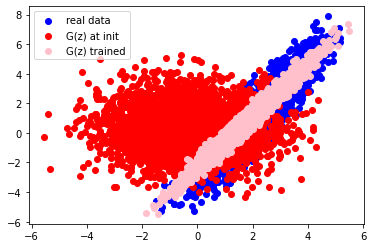

In [13]:
fake_data_trained = sample_G(model_G, 3200)

plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.scatter(fake_data_init[:,0], fake_data_init[:,1], color="red", label="G(z) at init")
plt.scatter(fake_data_trained[:,0], fake_data_trained[:,1], color="pink", label="G(z) trained")

plt.legend()

In [16]:
gA, gmu = model_G.parameters()
A.T @A
gA = gA.numpy()
gA.T @ gA

array([[1.1364958, 1.96862  ],
       [1.96862  , 3.5205662]], dtype=float32)

In [21]:
# Modularizing GAN "Loss"
class GANLoss:
    def __init__(self, model_D, opt_D):
        self.model_D = model_D
        self.opt_D = opt_D
        self.loss_D = nn.SoftmaxLoss()

    def _update_D(self, real_X, fake_X):
        real_Y = self.model_D(real_X)
        fake_Y = self.model_D(fake_X.detach())
        batch_size = real_X.shape[0]
        ones = init.ones(batch_size, dtype="int32")
        zeros = init.zeros(batch_size, dtype="int32")
        loss = self.loss_D(real_Y, ones) + self.loss_D(fake_Y, zeros)
        loss.backward()
        self.opt_D.step()

    def forward(self, fake_X, real_X):
        self._update_D(real_X, fake_X)
        fake_Y = self.model_D(fake_X)
        batch_size = real_X.shape[0]
        ones = init.ones(batch_size, dtype="int32")
        loss = self.loss_D(fake_Y, ones)
        return loss

In [22]:
model_G = nn.Sequential(nn.Linear(2, 2))
opt_G = kim.optim.Adam(model_G.parameters(), lr = 0.01)

model_D = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)
opt_D = kim.optim.Adam(model_D.parameters(), lr=0.01)
gan_loss = GANLoss(model_D, opt_D)


def train_gan(data, batch_size, num_epochs):
    assert data.shape[0] % batch_size == 0
    for epoch in range(num_epochs):
        begin = (batch_size * epoch) % data.shape[0]
        X = data[begin: begin+batch_size, :]
        Z = np.random.normal(0, 1, (batch_size, 2))
        X = kim.Tensor(X)
        Z = kim.Tensor(Z)
        fake_X = model_G(Z)
        loss = gan_loss.forward(fake_X, X)
        loss.backward()
        opt_G.step()

train_gan(data, 32, 2000)


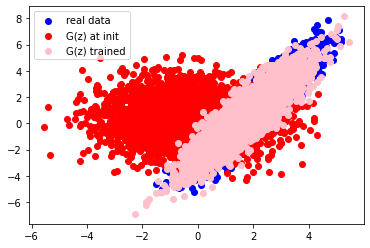

In [23]:
fake_data_trained = sample_G(model_G, 3200)

plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.scatter(fake_data_init[:,0], fake_data_init[:,1], color="red", label="G(z) at init")
plt.scatter(fake_data_trained[:,0], fake_data_trained[:,1], color="pink", label="G(z) trained")

plt.legend()